
Classification Performance Table:
                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.973684   0.972603  0.986111  0.979310
1                  SVM  0.982456   0.986111  0.986111  0.986111


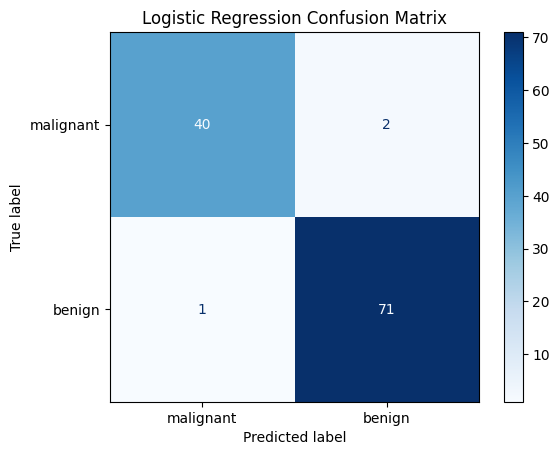

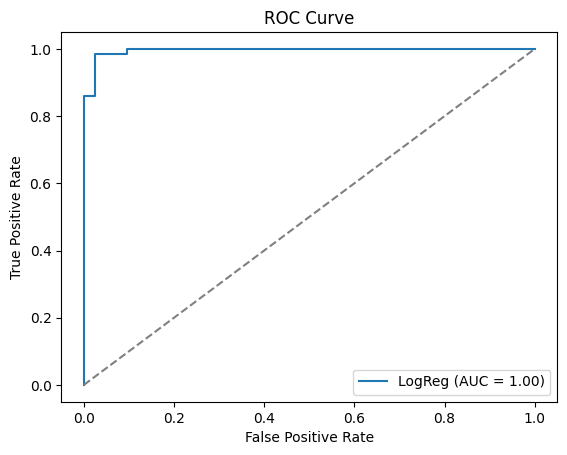


Regression Performance Table:
                     Model       MSE      RMSE      MAE       R^2
0  Random Forest Regressor  0.255867  0.505833  0.32793  0.804743


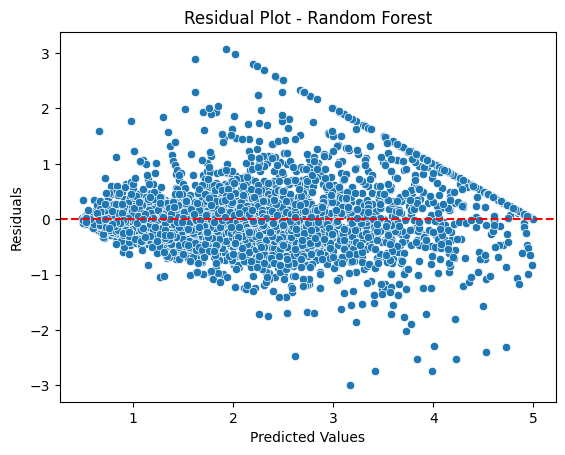

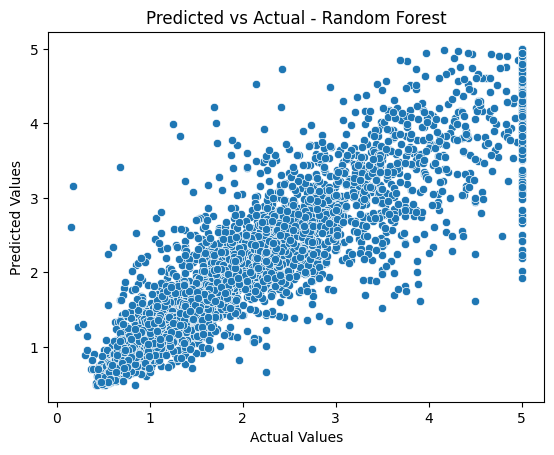

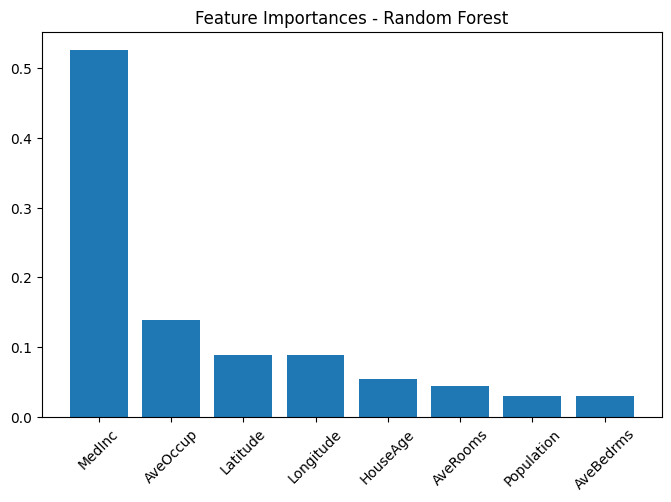


Hyperparameters Tested:
Logistic Regression: {'C': [0.01, 0.1, 1, 10]}
Best Params: {'C': 0.1}
SVM: {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
Best Params: {'C': 0.1, 'kernel': 'linear'}
Random Forest: {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
Best Params: {'max_depth': 20, 'n_estimators': 100}


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)

# -------------------------
# 1. Classification Dataset
# -------------------------
cancer = load_breast_cancer()
X_class, y_class = cancer.data, cancer.target

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Scaling for SVM and Logistic Regression
scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

# -------------------------
# Hyperparameter tuning: Logistic Regression
# -------------------------
param_log = {"C": [0.01, 0.1, 1, 10]}
grid_log = GridSearchCV(LogisticRegression(max_iter=500), param_log, cv=5)
grid_log.fit(Xc_train_scaled, yc_train)
log_reg = grid_log.best_estimator_
yc_pred_log = log_reg.predict(Xc_test_scaled)

# -------------------------
# Hyperparameter tuning: SVM
# -------------------------
param_svm = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
grid_svm = GridSearchCV(SVC(probability=True), param_svm, cv=5)
grid_svm.fit(Xc_train_scaled, yc_train)
svm = grid_svm.best_estimator_
yc_pred_svm = svm.predict(Xc_test_scaled)

# -------------------------
# Classification Evaluation
# -------------------------
def evaluate_classification(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

results_class = []
results_class.append(evaluate_classification(yc_test, yc_pred_log, "Logistic Regression"))
results_class.append(evaluate_classification(yc_test, yc_pred_svm, "SVM"))

# Performance table for classification
print("\nClassification Performance Table:")
print(pd.DataFrame(results_class))

# Confusion Matrix example
cm = confusion_matrix(yc_test, yc_pred_log)
ConfusionMatrixDisplay(cm, display_labels=cancer.target_names).plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# ROC Curve example
log_probs = log_reg.predict_proba(Xc_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(yc_test, log_probs)
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc_score(yc_test, log_probs):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# -------------------------
# 2. Regression Dataset
# -------------------------
housing = fetch_california_housing()
X_reg, y_reg = housing.data, housing.target

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Hyperparameter tuning: Random Forest Regressor
param_rf = {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_rf, cv=3)
grid_rf.fit(Xr_train, yr_train)
rf_reg = grid_rf.best_estimator_
yr_pred = rf_reg.predict(Xr_test)

# Regression Evaluation
reg_results = {
    "Model": "Random Forest Regressor",
    "MSE": mean_squared_error(yr_test, yr_pred),
    "RMSE": np.sqrt(mean_squared_error(yr_test, yr_pred)),
    "MAE": mean_absolute_error(yr_test, yr_pred),
    "R^2": r2_score(yr_test, yr_pred)
}

print("\nRegression Performance Table:")
print(pd.DataFrame([reg_results]))

# Residual plot
residuals = yr_test - yr_pred
sns.scatterplot(x=yr_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.show()

# Predicted vs Actual
sns.scatterplot(x=yr_test, y=yr_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual - Random Forest")
plt.show()

# Feature Importance (Fixed)
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
n_features = len(importances)  # number of available features
plt.figure(figsize=(8,5))
plt.bar(range(n_features), importances[indices][:n_features])
plt.xticks(range(n_features), [housing.feature_names[i] for i in indices[:n_features]], rotation=45)
plt.title("Feature Importances - Random Forest")
plt.show()


# -------------------------
# 2.5 Result Reporting Tables
# -------------------------

# Hyperparameters tested
print("\nHyperparameters Tested:")
print("Logistic Regression:", param_log)
print("Best Params:", grid_log.best_params_)
print("SVM:", param_svm)
print("Best Params:", grid_svm.best_params_)
print("Random Forest:", param_rf)
print("Best Params:", grid_rf.best_params_)